In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
from pandas.io.json import json_normalize

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [9]:
start_dt = '2021-09-01'
end_dt = '2021-09-14'

(1) Identify hours where the System is throttling Traffic because of Load Issues/Timeouts

(2) Identify pockets of inventory that we should be throttling if the system is overloaded versus everywhere (Dynamic Throttling). 


In [10]:
df = bigquery_client.query(f"""
select
    date(etimestamp) as edate
    , extract(hour from etimestamp) as ehour
    , extract(minute from etimestamp) as eminute
    , sum(if(event_type = 'clear',1,0))*16 impressions
    , sum(if(event_type = 'click',1,0))*16 clicks
    , sum(if(event_type = 'install',1,0))*16 installs
    , sum(if(event_type = 'install',revenue,0))*16 revenue
    , sum(if(event_type = 'clear',settlement_price,0))*16/1000 cost
from stats.rows1 
where 
    date(etimestamp) >= '{start_dt}'
    and date(etimestamp) <= '{end_dt}'
    and right(tid,1) = '0'
group by 1,2,3
""").to_dataframe()
df['first_qtr_hr'] = np.where(df.eminute < 15, True, False)
df

edate  ehour  eminue  impressions  clicks  installs  revenue  \
0      2021-09-01      0      27       111536    2784       112   164.00   
1      2021-09-13      0      42       109184    2720       160   202.88   
2      2021-09-13      0      25        93232    2336       144   208.80   
3      2021-09-02      0      50       102032    2896       192   327.52   
4      2021-09-08      0      42       108672    3232       144   133.76   
...           ...    ...     ...          ...     ...       ...      ...   
20155  2021-09-02     23      46        93616    2528       160   215.52   
20156  2021-09-01     23      34       102528    2176        64    45.44   
20157  2021-09-13     23      21        88416    2592       176   276.80   
20158  2021-09-05     23      43        86960    2016       192   199.20   
20159  2021-09-08     23      28        77408    1936       224   269.60   

             cost  
0      192.716260  
1      341.577313  
2      217.891517  
3      211.822270  
4      319.628993  
...           ...  
20155  157.044056  
20156  167.357544  
20157  171.317727  
20158  214.806780  
20159  154.022341  

[20160 rows x 8 columns]

In [30]:
by_date_hour = df.pivot_table(values = ['cost'], index = ['edate','ehour'], columns = ['first_qtr_hr'], aggfunc = np.sum, margins = True).iloc[:-1]
by_date_hour['capped'] = np.where(by_date_hour[('cost',True)] > 22000/4, True, False)
by_date_hour[by_date_hour.index.get_level_values(0).isin([datetime.date(2021,9,7),datetime.date(2021,9,14)])]


cost                            capped
first_qtr_hr             False         True           All       
edate      ehour                                                
2021-09-07 0      11040.078127  2877.955394  13918.033521  False
           1      10533.658938  4016.142592  14549.801530  False
           2       8928.462826  2966.090123  11894.552948  False
           3       6250.882631  2329.407466   8580.290096  False
           4       5169.594342  2207.842644   7377.436986  False
           5       4175.483120  1676.420260   5851.903380  False
           6       2858.948142  1311.378403   4170.326545  False
           7       2207.214438   981.157388   3188.371826  False
           8       2068.755963   793.020160   2861.776124  False
           9       2194.419802   811.888664   3006.308466  False
           10      3038.692845   995.800217   4034.493062  False
           11      4201.307028  1485.144458   5686.451486  False
           12      4766.490348  1741.171863   6507.662211  False
           13      5071.628490  2176.608860   7248.237350  False
           14      5567.969537  2233.051638   7801.021175  False
           15      5726.246446  1989.288715   7715.535161  False
           16      6048.329605  2485.719441   8534.049046  False
           17      5978.915373  2280.121247   8259.036620  False
           18      6289.919012  1902.499910   8192.418922  False
           19      7709.112367  2269.078523   9978.190890  False
           20     10946.433176  5683.717214  16630.150390   True
           21      9424.671276  3106.679549  12531.350825  False
           22      9747.480421  3038.462567  12785.942989  False
           23      8911.311952  3184.004987  12095.316939  False
2021-09-14 0      13273.322283  2590.760149  15864.082432  False
           1      11018.566775  5662.825954  16681.392728   True
           2      10644.920979  5018.004282  15662.925261  False
           3       8670.745080  4584.981669  13255.726749  False
           4       5719.544210  2840.401055   8559.945264  False
           5       4744.956970  2022.853154   6767.810124  False
           6       3173.063644  1552.675365   4725.739009  False
           7       2656.836282  1126.374903   3783.211185  False
           8       2518.486010  1043.570063   3562.056073  False
           9       3012.244270  1127.791392   4140.035662  False
           10      4257.640949  1469.812075   5727.453024  False
           11      5443.197746  2020.616726   7463.814473  False
           12      5863.994844  2353.361716   8217.356559  False
           13      6072.536441  2489.593904   8562.130345  False
           14      6692.899823  2774.943753   9467.843576  False
           15      6632.408547  2689.453294   9321.861841  False
           16      6966.733335  2608.870204   9575.603540  False
           17      7381.010567  3082.055309  10463.065876  False
           18      7551.185369  2750.891569  10302.076938  False
           19      8017.320912  3215.144580  11232.465492  False
           20      8607.270231  3026.374494  11633.644725  False
           21      7936.838747  2933.377500  10870.216247  False
           22      8279.072323  2492.967692  10772.040015  False
           23      8552.091844  2574.023521  11126.115365  False

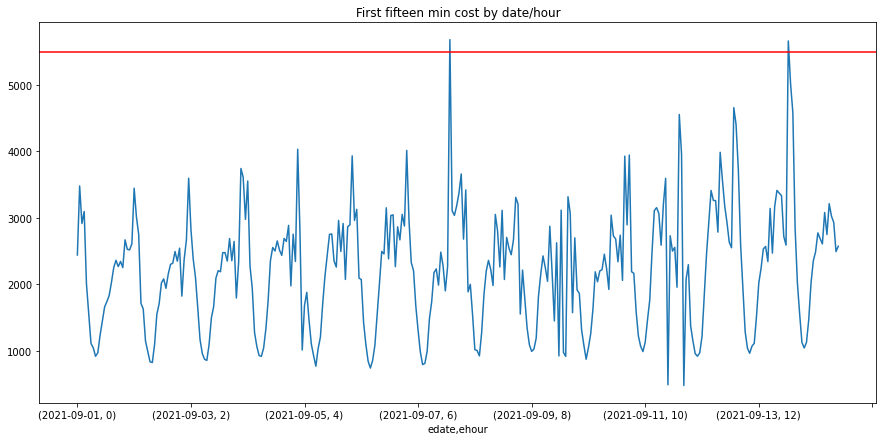

In [32]:
by_date_hour[('cost',True)].plot(figsize = (15,7), title = 'First fifteen min cost by date/hour')
plt.gca().axhline(y = 22000/4, color = 'red')

Looks like we have hit the fifteen minute cap, thus resulting in more aggressive throttling, a few times in the past few weeks.

<AxesSubplot:xlabel='eminute'>

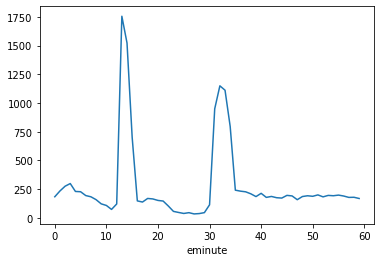

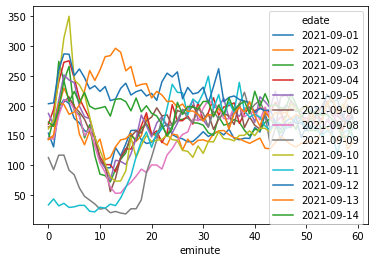

In [50]:
df[(df.edate == datetime.date(2021,9,7)) & (df.ehour == 20)].set_index('eminute').sort_index()['cost'].plot()
df[(df.edate != datetime.date(2021,9,7)) & (df.ehour == 20)].pivot_table(values = 'cost', index = 'eminute', columns = 'edate', aggfunc = np.sum).plot()

<AxesSubplot:xlabel='eminute'>

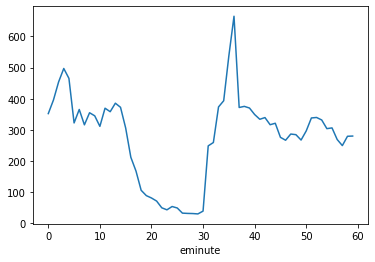

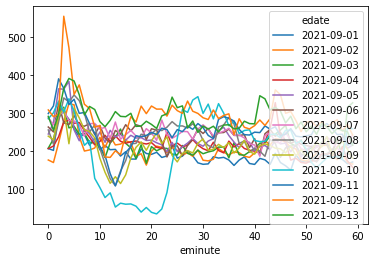

In [49]:
df[(df.edate == datetime.date(2021,9,14)) & (df.ehour == 1)].set_index('eminute').sort_index()['cost'].plot()
df[(df.edate != datetime.date(2021,9,14)) & (df.ehour == 1)].pivot_table(values = 'cost', index = 'eminute', columns = 'edate', aggfunc = np.sum).plot()